In [1]:
import pandas as pd
import numpy as np
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pymop import Problem
import os
from tslearn.datasets import UCR_UEA_datasets
import warnings
warnings.filterwarnings('ignore')
import pickle


In [2]:
dataset='ECG5000'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
enc1=pickle.load(open(f'../../ClassificationModels//models/{dataset}/OneHotEncoder.pkl','rb'))
test_y=enc1.transform(test_y.reshape(-1,1))
n_classes = test_y.shape[1]


In [3]:
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, get_all_preds
stride = 1
kernel_size=10
padding = kernel_size - 1
input_size= train_x.shape[-1]
device = torch.device( "cpu")#"cuda:0" if torch.cuda.is_available() else
model = ResNetBaseline(in_channels= 1, num_pred_classes=2)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/GunPoint/ResNet'))
test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)


In [4]:
model.eval()
y_pred,labels= get_all_preds(model,test_loader)
#y_pred= model(test_x).detach().numpy()

In [5]:
observation_01, label_01 = test_dataset[0]
label_01=np.array([y_pred[0]])
print(observation_01.shape)
print(label_01.shape)


(1, 140)
(1,)


In [6]:
from TSInterpret.InterpretabilityModels.counterfactual.TSEvoCF import TSEvo
exp =TSEvo(model= model,data=(test_x,np.array(y_pred)), mode = 'feat',backend='PYT')

2022-12-21 14:51:32.937268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 14:51:35.943489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-21 14:51:35.943864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-21 14:51:35.943907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<class 'numpy.int64'>


In [7]:
label_01

array([1])

In [8]:
#TODO Call Explain Instead, Make return label &exp
pop,label_cf=exp.explain(observation_01.reshape(1,1,-1),np.array(label_01),epochs =100)

1
(1, 1, 140)
No Target


In [9]:
np.array(pop).shape

(140,)

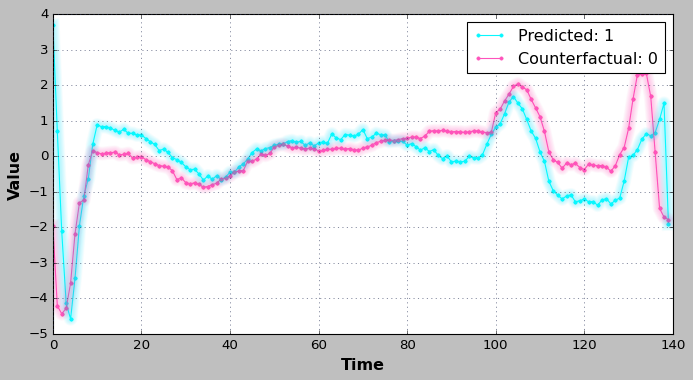

In [10]:
exp.plot_in_one(observation_01,label_01[0],pop,np.argmax(label_cf),save_fig=None)